# Fraud Detection using Supervised Learning

# 0. Project Objective
The goal of this project is to develop a supervised machine learning model that can accurately detect fraudulent credit card transactions. Given a dataset of anonymized transactions, the primary objective is to build a classifier that can distinguish between legitimate and fraudulent activities.

A key challenge in this task is the severe class imbalance in the dataset—fraudulent transactions represent a very small fraction of the total transactions. Therefore, a major focus will be on handling this imbalance and evaluating the model not just on overall accuracy, but on its ability to correctly identify fraud cases, which is best measured by the recall metric. The aim is to build a model that effectively minimizes false negatives (i.e., failing to detect an actual fraudulent transaction).

In [1]:
# Importing necessary Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, fbeta_score
from sklearn.model_selection import GridSearchCV

root = '/Users/mina/Documents/GitHub/fraud_detection/'

# 1. Dataset Exploration
## 1.1 About data

The dataset contains 284,807 credit card transactions made over a period of two days. It has 31 features, which include:

* `Time`: The number of seconds elapsed between a transaction and the very first transaction in the dataset.
* `V1`-`V28`: Anonymized features that are the result of a Principal Component Analysis (PCA) transformation. This was done to protect confidential user data.
* `Amount`: The transaction amount in US dollars.
* `Class`: The target variable, where:
    * `0`: Indicates a normal transaction
    * `1`: Indicates a fraudulent transaction

## 1.2 Import dataset

In [2]:
data = pd.read_csv(root + 'creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.shape

(284807, 31)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
data.isna().any().any()

False

* The dataset has 284,807 rows and 31 columns.
* There are no missing values in any of the columns.
* All features are numerical (*float64* or *int64*), which is suitable for direct use in machine learning models.

## 1.3 Exploratory Data Analysis (EDA)

### Class Distribution

In [6]:
# Check the class distribution (fraud distribution)
data['Class'].value_counts(normalize=True) 

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

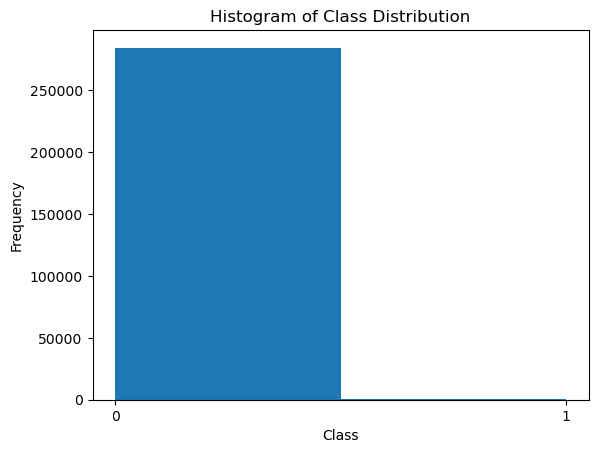

In [7]:
# histogram of class distribution
plt.hist(data['Class'], bins=2)
plt.xticks([0, 1])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Class Distribution')
plt.show()

The output shows that only 0.17% of transactions are fraudulent. This confirms the dataset is extremely imbalanced, which is a critical point to consider during modeling. A model trained on this data might achieve high accuracy by simply predicting all transactions as "normal," but it would fail at the primary goal of detecting fraud.

### V1 - V28 Features
These features are PCA-transformed and anonymized.

In [8]:
# Summary statistics for continous values
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Since the `V1`-`V28` features are the result of PCA, they have already been standardized (centered around zero). Therefore, no further scaling is required for these specific columns.

### Time Feature
The `Time` feature represents the seconds since the first transaction. Visualizing its distribution might reveal patterns related to the time of day.

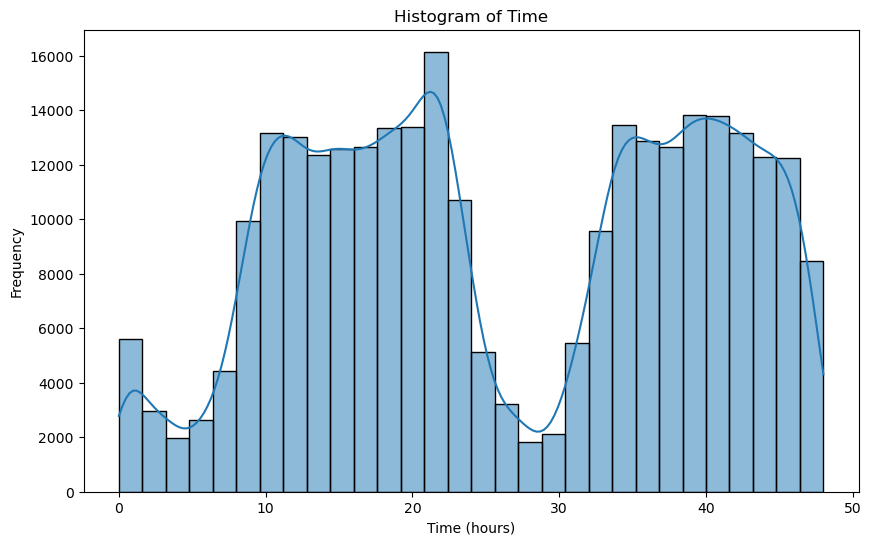

In [9]:
# plot thedistribution of Time
plt.figure(figsize=(10, 6))
sns.histplot(data['Time']/3600, bins=30, kde=True)
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Time')
plt.show()


The histogram shows a bimodal distribution, suggesting transaction frequency varies, likely due to daily cycles (e.g., lower activity during nighttime). Let's see if there's a significant difference in transaction times between normal and fraudulent transactions.

In [10]:
# check the time since transactions by the fraud class
data.groupby('Class')['Time'].agg(['min','max','mean','median'])

,min,max,mean,median
Class,,,,
0,0.0,172792.0,94838.202258,84711.0
1,406.0,170348.0,80746.806911,75568.5


The minimum time of fraud transaction since the first transaction is 406 seconds while the normal transactions only took 0 seconds. Others including max, mean, median of time appears similar in both fraud and normal transactions. 

This indicates that fraud transactions occurred almost the same timeframe as legitimate ones but they don't appear in the very early preiods.

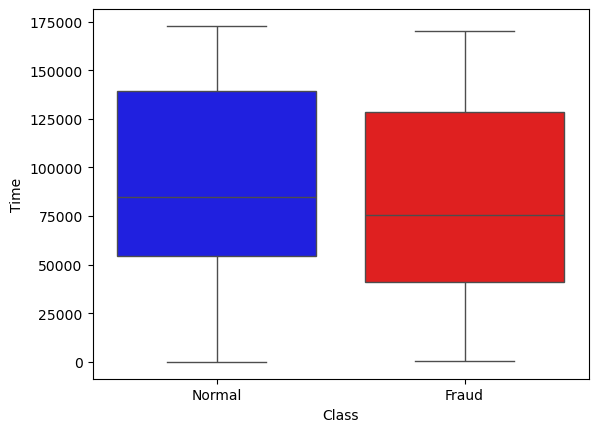

In [11]:
# boxplot of time by the fraud class
sns.boxplot(x='Class', y='Time', data=data, palette=['blue', 'red'])
plt.xticks([0, 1], ['Normal', 'Fraud'])
plt.show()

The boxplot reveals that the distribution of transaction times is similar for both normal and fraudulent transactions. Fraud occurs throughout the entire time period, much like normal transactions. This suggests that `Time`, on its own, may not be a strong predictor of fraud.

### Amount Feature

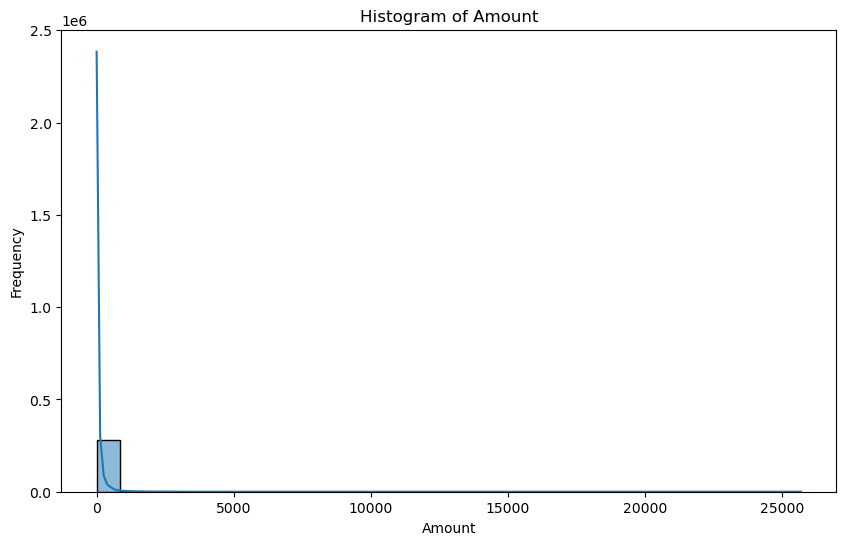

In [12]:
# plot the distribution of Amount
plt.figure(figsize=(10, 6))
sns.histplot(data['Amount'], bins=30, kde=True)
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Amount')
plt.show()

The `Amount` data is highly right-skewed. We will address this extreme skewness during the data processing stage.

In [13]:
# check the amount of fraud transactions by the fraud class
data.groupby('Class')['Amount'].agg(['min','max','mean','median'])

,min,max,mean,median
Class,,,,
0,0.0,25691.16,88.291022,22.00
1,0.0,2125.87,122.211321,9.25


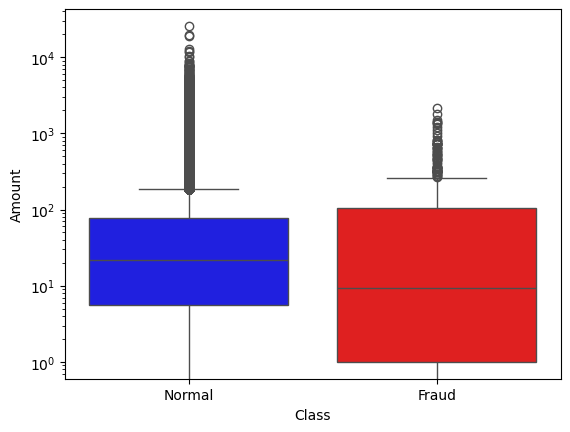

In [14]:
# boxplot of amount (log scale) by the fraud class
sns.boxplot(x='Class', y='Amount', data=data, palette=['blue', 'red'])
plt.xticks([0, 1], ['Normal', 'Fraud'])
plt.yscale('log')
plt.show()

From the summary statistics and the log-scaled boxplot, we can observe:

* Fraudulent transactions tend to involve smaller amounts on average (median of $9.25 vs. $22.00 for normal transactions).

* The interquartile range (IQR) for fraudulent transactions is wider, indicating more variability in their amounts compared to normal ones.

* Despite the lower median, fraudulent transactions still have outliers, though the maximum fraud amount ($2,125) is much lower than the maximum normal amount ($25,691).

Unlike `Time`, the `Amount` feature appears to show a discernible difference between the two classes and could be a useful predictor.

# 2. Data Preprocessing

Based on the EDA, we will perform the following preprocessing steps:

* Transform `Time`: Convert `Time` from seconds to hours for better interpretability. We will then scale this feature.

* Log-Transform `Amount`: Apply a log transformation to the `Amount` feature to reduce its skewness, making its distribution more normal.

* Scale Features: Standardize the new Hours and log-transformed `Amount` features so they have a mean of 0 and a standard deviation of 1. This ensures they are on a similar scale as the PCA-derived `V` features.

## 2.1 Time Conversion

In [15]:
# convert time to hours
data['Hours'] = data['Time'] / 3600 

# drop the original Time column
data = data.drop(columns=['Time'])

## 2.2 Log transformation

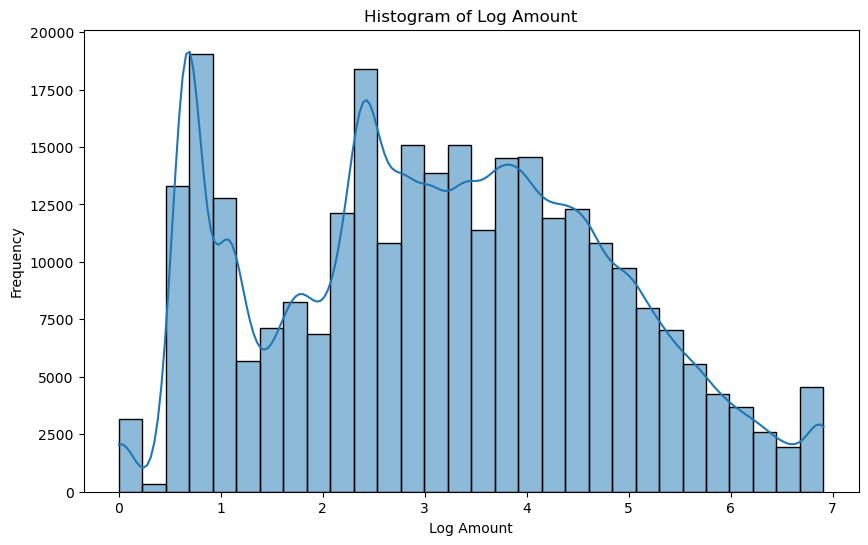

In [16]:
# log transform the amount
data['log_amount'] = np.log1p(np.clip(data['Amount'], 0, 1000))

# plot the histogram of log_amount
plt.figure(figsize=(10, 6))
sns.histplot(x='log_amount', data=data, bins=30, kde=True)
plt.xlabel('Log Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Log Amount')
plt.show()

In [17]:
# drop the original Amount column
data = data.drop(columns=['Amount'])

## 2.3 Scale Features

In [18]:
# scale the data
SS = StandardScaler()

# handle zero values before log transform by adding a small constant
data['log_amount'] = data['log_amount'].replace([np.inf, -np.inf], np.nan).fillna(data['log_amount'].mean())

# scale all numeric features
data[['scaled_log_amount', 'scaled_Hours']] = SS.fit_transform(data[['log_amount', 'Hours']])


In [19]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Class,Hours,log_amount,scaled_log_amount,scaled_Hours
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000,2.848070e+05,2.848070e+05
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,0.001727,26.337183,3.147242,3.911881e-17,-1.021879e-16
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527,13.191152,1.644108,1.000002e+00,1.000002e+00
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,0.000000,-1.914258e+00,-1.996583e+00
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000,15.055972,1.887070,-7.664794e-01,-8.552120e-01
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000,23.525556,3.135494,-7.145638e-03,-2.131453e-01
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000,38.700139,4.358822,7.369234e-01,9.372174e-01
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000,47.997778,6.908755,2.287878e+00,1.642058e+00


In [20]:
# drop the original Hours and log_amount columns
data = data.drop(columns=['Hours', 'log_amount'])

In [21]:
# Save data with feature engineering without resampling
data.to_pickle('data_feature_engineering.pkl')

## 2.4 Resampling
To address the severe class imbalance, we will use an undersampling technique. This method reduces the number of instances in the majority class (normal transactions) to match the number in the minority class (fraudulent transactions). Since our dataset is large, we can afford to remove samples from the majority class without losing too much information, resulting in a balanced 50:50 dataset for training our model.

In [22]:
# Split the data into X and y
X = data.drop(columns=['Class'])
y = data['Class']

In [23]:
# Apply Undersampling to balance the classes
under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Create a new DataFrame with the resampled data
resampled_data = pd.DataFrame(X_resampled)
resampled_data['Class'] = y_resampled

In [24]:
# Check the class distribution after resampling
y_resampled.value_counts(normalize=True)

Class
0    0.5
1    0.5
Name: proportion, dtype: float64

In [25]:
y_resampled.value_counts()

Class
0    492
1    492
Name: count, dtype: int64

After undersampling, we have a perfectly balanced dataset with 492 normal and 492 fraudulent transactions.

In [26]:
# Create a new DataFrame with the resampled data
resampled_data = pd.DataFrame(X_resampled)
resampled_data['Class'] = y_resampled

# 3. Modeling
We will now train and evaluate several classification models on the resampled data. Our primary evaluation metric will be recall on the fraud class (`Class`=1), as it is crucial to minimize false negatives (i.e., failing to detect fraud).

We will use the following models:

* Logistic Regression
* Random Forest Classifier
* Support Vector Classifier (SVC)
* XGBoost Classifier

We'll use **Stratified K-Fold Cross-Validation** to get a reliable estimate of each model's performance.

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

## 3.1 Selet a model

In [28]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    SVC(),
    XGBClassifier()
]

In [29]:
# Conduct cross-validation
cv_results = []
for model in classifiers:
    cv_results.append(cross_val_score(model, X_train_undersampled, y_train_undersampled, scoring = "recall", cv = cv, n_jobs=-1))

In [30]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [31]:
# evaluate the results
cv_results_all = pd.DataFrame({"Algorithm":["LogisticRegression","RandomForestClassifier","SVC","XGBClassifier"],
                                "CrossValMeans":cv_means,"CrossValerrors": cv_std})

In [32]:
cv_results_all.round(5)

,Algorithm,CrossValMeans,CrossValerrors
0,LogisticRegression,0.92645,0.03696
1,RandomForestClassifier,0.90617,0.03793
2,SVC,0.88338,0.04170
3,XGBClassifier,0.91373,0.03136


The cross-validation results show that Logistic Regression has the highest mean recall score (0.926), closely followed by XGBoost (0.914). Given its strong performance and simplicity, we will select Logistic Regression for further tuning and final evaluation.

Text(0.5, 1.0, 'Cross validation scores')

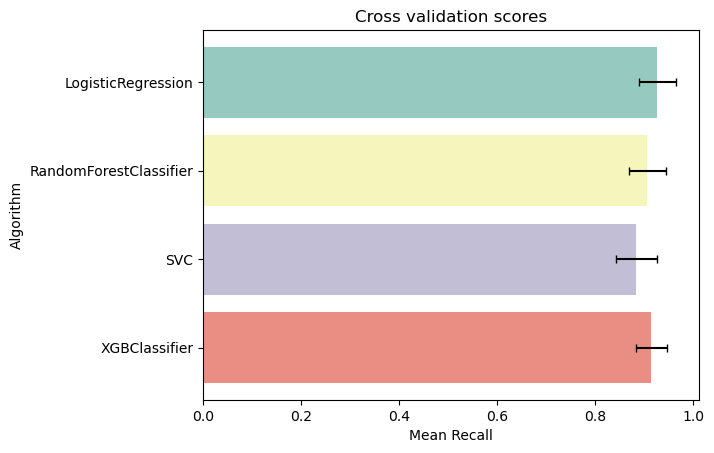

In [33]:
# plot the results
g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_results_all, palette="Set3", orient="h")
plt.errorbar(x=cv_results_all["CrossValMeans"], y=range(len(cv_results_all)), xerr=cv_std, fmt='none', c='black', capsize=3)
g.set_xlabel("Mean Recall")
g.set_title("Cross validation scores")

In [34]:
# Compare Logistic Regression, XGBoost, LightGBM from cross-validation results
LR = LogisticRegression()
xgb = XGBClassifier()

LR.fit(X_train_undersampled, y_train_undersampled)
xgb.fit(X_train_undersampled, y_train_undersampled)

LR_pred = LR.predict(X_test_undersampled)
xgb_pred = xgb.predict(X_test_undersampled) 

Text(627.9949494949494, 0.5, 'Actual')

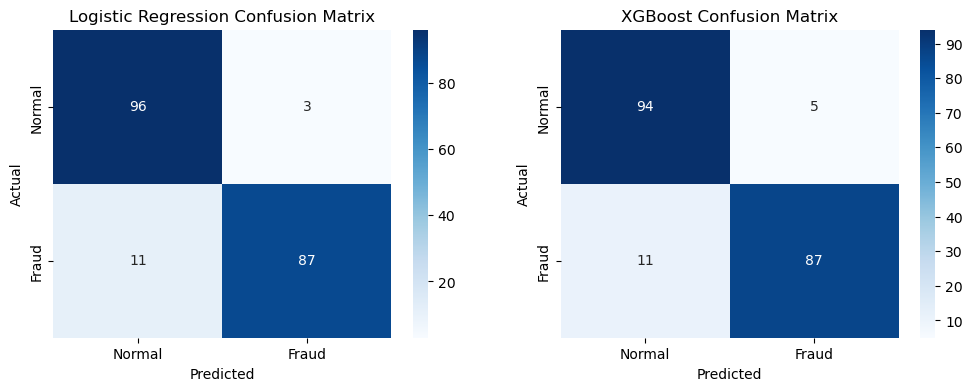

In [35]:
# Compare Logistic Regression and Random Forest from cross-validation results
LR_conf_matrix = confusion_matrix(y_test_undersampled, LR_pred)
xgb_conf_matrix = confusion_matrix(y_test_undersampled, xgb_pred)

# Plot the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 4))   
sns.heatmap(LR_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], ax=ax[1])
ax[1].set_title('XGBoost Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')



In [36]:
LR_scores = classification_report(y_test_undersampled, LR_pred)
xgb_scores = classification_report(y_test_undersampled, xgb_pred)

print(LR_scores)
print(xgb_scores)
print("Logistic Regression ROC AUC score: ", roc_auc_score(y_test_undersampled, LR_pred))
print("XGBoost ROC AUC score: ", roc_auc_score(y_test_undersampled, xgb_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        99
           1       0.97      0.89      0.93        98

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        99
           1       0.95      0.89      0.92        98

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197

Logistic Regression ROC AUC score:  0.928726035868893
XGBoost ROC AUC score:  0.918625025767883


The initial test on the undersampled data shows both models perform well, with both Logistic Regression achieving a slightly higher f1-score, accuracy and ROC AUC score.

# 3.2 Hyperparameter tuning

To optimize our selected model, we will perform hyperparameter tuning on the Logistic Regression classifier using GridSearchCV. This will help us find the best combination of parameters (`penalty` and `C`) to maximize recall.

In [37]:
# Set up parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10]
}

In [38]:
# GridSearchCV
grid_search = GridSearchCV(estimator = LR, param_grid = param_grid, 
                          scoring = 'recall', cv = 5, n_jobs = -1)
grid_search.fit(X_train_undersampled, y_train_undersampled)
# Get the best parameters
grid_search.best_params_


{'C': 10, 'penalty': 'l2'}

In [39]:
# Get the best model
LR_best = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       0.91      0.96      0.94        99
           1       0.96      0.91      0.93        98

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197

ROC AUC score:  0.933879612451041


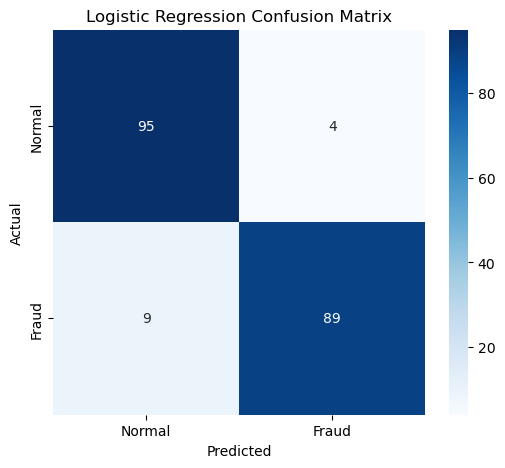

In [40]:
# Evaluate the best model
LR_best_pred = LR_best.predict(X_test_undersampled)

# Plot the confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_undersampled, LR_best_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], ax=ax)
ax.set_title('Logistic Regression Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
# Print the classification report
print(classification_report(y_test_undersampled, LR_best_pred))

# Print the ROC AUC score
print("ROC AUC score: ", roc_auc_score(y_test_undersampled, LR_best_pred))

Text(0, 0.5, 'True Positive Rate')

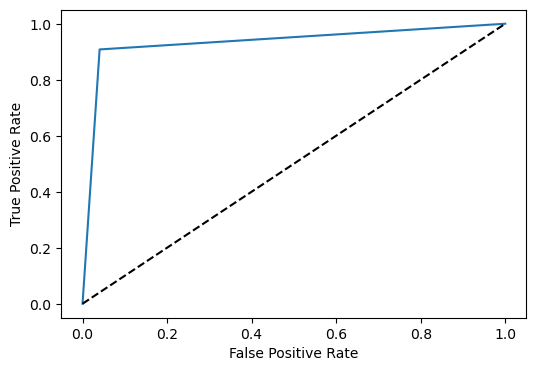

In [41]:
# ROC AUC curve
fpr, tpr, thresholds = roc_curve(y_test_undersampled, LR_best_pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC AUC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## 3.3 Test on the original training set without undersampling


              precision    recall  f1-score   support

           0       1.00      0.96      0.98    227451
           1       0.04      0.93      0.07       394

    accuracy                           0.96    227845
   macro avg       0.52      0.94      0.52    227845
weighted avg       1.00      0.96      0.98    227845

ROC AUC score:  0.9449102073572069


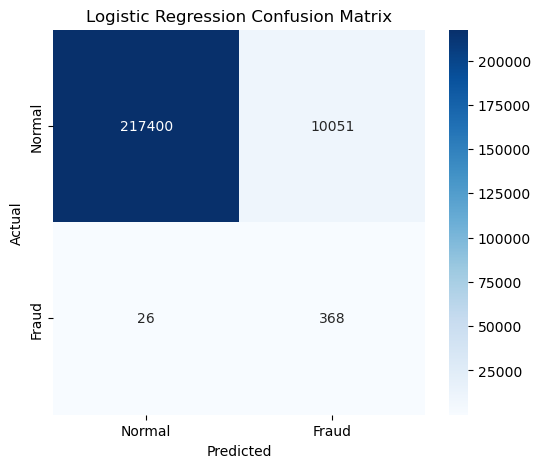

In [42]:
# Evaluate the best model
LR_best_pred = LR_best.predict(X_train)

# Plot the confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(confusion_matrix(y_train, LR_best_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], ax=ax)
ax.set_title('Logistic Regression Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
# Print the classification report
print(classification_report(y_train, LR_best_pred))

# Print the ROC AUC score
print("ROC AUC score: ", roc_auc_score(y_train, LR_best_pred))

The current model achieves very high recall, correctly identifying most fraudulent transactions, but it also produces many false positives by misclassifying normal transactions as fraud. 

If review capacity is large, this trade-off may be acceptable since flagged transactions can be corrected during the review process. However, if the cost of investigating false positives is significant, it is necessary to find the best model with high f1/f2 score to balance recall (capturing fraud) with precision (reducing false alarms).

I will recalibrate the decision threshold to balance recall and precision, then determine the most appropriate strategy.

## 3.4 Choose thresholds to balance both recall and precision

In [43]:
# Get model scores
y_train_scores = LR.predict_proba(X_train)[:, 1]


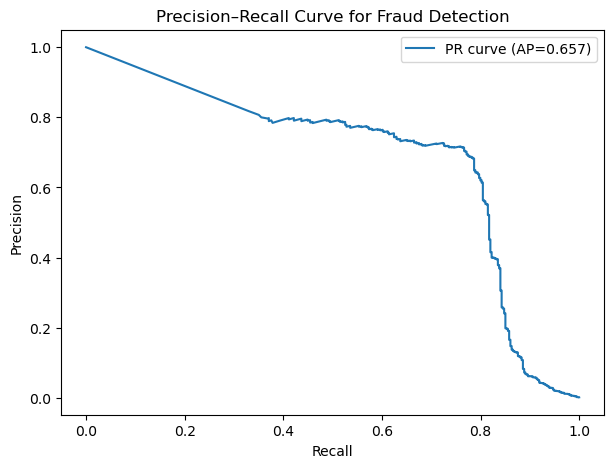

In [44]:
# Compute precision and recall curve
prec, rec, thr = precision_recall_curve(y_train, y_train_scores)
ap = average_precision_score(y_train, y_train_scores)

plt.figure(figsize=(7,5))
plt.plot(rec, prec, label=f'PR curve (AP={ap:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve for Fraud Detection")
plt.legend()
plt.show()

In [45]:
# Choose a threshold that balances recall and precision
def best_threshold_fbeta(y_train, y_train_scores, beta=1):
    prec, rec, thr = precision_recall_curve(y_train, y_train_scores)
    fbeta = (1+beta**2) * (prec*rec) / (beta**2*prec + rec + 1e-12)
    best_idx = np.argmax(fbeta)
    return thr[max(0, best_idx-1)], prec[best_idx], rec[best_idx], fbeta[best_idx]

thr_f2, p_f2, r_f2, f2 = best_threshold_fbeta(y_train, y_train_scores, beta=2)
print(f"F2-optimal threshold: {thr_f2:.4f}, Precision={p_f2:.3f}, Recall={r_f2:.3f}, F2={f2:.3f}")

F2-optimal threshold: 1.0000, Precision=0.683, Recall=0.787, F2=0.764


At the F2-optimal threshold (balancing precision/recall with extra weight on recall), the model achieves 68% precision and 79% recall, which is a substantial improvement over the default threshold (3% precision, 94% recall). This threshold represents a more practical balance for fraud detection when false positives are costly, although it does miss some fraud cases compared to the default. 

The “best” threshold ultimately depends on organizational priorities: if minimizing missed fraud is critical, a lower threshold may be preferred, whereas if review costs dominate, this setting is much more effective.

In terms of the trade-off between recall and precision, I will prioritize a higher recall score, since missing fraud is costly, particularly for high-value transactions, and could harm the long-term trust in the credit card company.

# 4.Final Evaluation

Now, we will evaluate our fine-tuned Logistic Regression model on the original, imbalanced test set. It is critical to test the model on data that reflects the real-world distribution to understand its true performance.

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.03      0.94      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.95      0.52     56962
weighted avg       1.00      0.96      0.98     56962

Logistic Regression ROC AUC score:  0.9470537652314726


Text(0, 0.5, 'True Positive Rate')

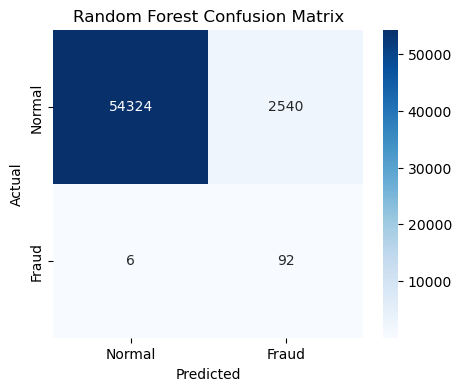

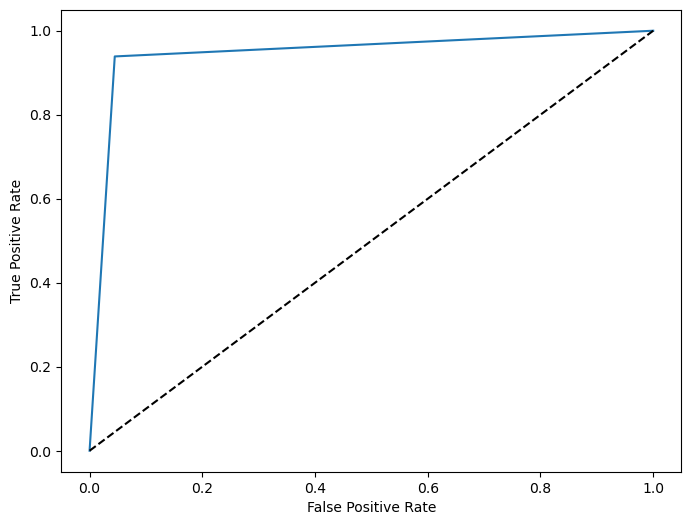

In [46]:
# Final model prediction
final_pred = LR_best.predict(X_test)

# Print the classification report
print(classification_report(y_test, final_pred))

# Print the ROC AUC score
print("Logistic Regression ROC AUC score: ", roc_auc_score(y_test, final_pred))

# Plot the confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, final_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], ax=ax)
ax.set_title('Random Forest Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Plot the ROC AUC curve
fpr, tpr, thresholds = roc_curve(y_test, final_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# 5. Conclusion
The final evaluation provides a clear picture of the model's performance:

* Recall: The model successfully identified 94% of the actual fraudulent transactions in the test set (a recall of 0.94 for class 1). This is an excellent result and meets our primary objective of minimizing false negatives.

* Precision: However, the precision for the fraud class is very low at 3%. This means that out of all the transactions the model flagged as fraudulent, only 3% were actually fraud. This leads to a high number of false positives.

* ROC AUC Score: The ROC AUC score of 0.95 indicates that the model has a strong ability to distinguish between the two classes.

## Final Thoughts:
The tuned Logistic Regression model is highly effective at catching fraudulent activity. The trade-off is that it generates many false alarms. In a real-world scenario, these flagged transactions would likely be sent for further review. The business would need to weigh the cost of reviewing false positives against the cost of missing fraudulent transactions to determine if this model is suitable for deployment.